In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

# Class 12: Introduction to the `linearsolve` Module

In general, dynamic stochastic general equilibrium (DSGE) models do not admit analytic (i.e., pencil-and-paper) solutions and they are time-consuming to work with. The `linearsolve` module approximates, solves, and simulates DSGE models and therefore makes DSGE models easier to use.

## Installing `linearsolve`

`linearsolve` is not included in the Anaconda Python installation and so before you can import it, you need to download and install the `linearsolve` package from PyPI, the Python Package Index. In Windows, open the Anaconda Prompt and in Mac, open the Terminal and run the following commmand:

    pip install linearsolve
    
You only have to install the package once.

In [2]:
# Import the linearsolve under the 'ls' namespace
import linearsolve as ls

## Example: A One-Equation Model of TFP

Consider the following AR(1) specification for $\log$ TFP:

\begin{align}
\log A_{t+1} & = \rho \log A_t + \epsilon_{t+1},
\end{align}

where $\epsilon_{t+1} \sim \mathcal{N}(0,\sigma^2)$. The goal is to simulate 

\begin{align}
\log (A_{t}/\bar{A}) & \approx \frac{A_t - \bar{A}}{\bar{A}},
\end{align}

where $\bar{A}$ is the nonstochastic (i.e., $\epsilon_t = 0$) steady state value of $A_t$. Let's compute the model simulation with `linearsolve`. To do this we need to do several things:

1. Create a Pandas series that stores the names of the parameters of the model.
2. Define a function that returns the equilibrium conditions of the model solved for zero.
3. Initialize an instance of the `linearsolve.model` class
4. Compute and input the steady state of the model.
5. Approximate and solve the model.
6. Compute simulations of the model.

Use the following values for the simulation:

| $$\rho$$ | $$\sigma$$ |
|----------|------------|
| 0.95     | 0.01       |

**Step 1:** Create a variable called `parameters` that stores parameter values as a Pandas Series.

In [3]:
# Create a variable called 'parameters' that stores the model parameter values in a Pandas Series
parameters = pd.Series(dtype=float)
parameters['rho'] = .95

# Print stored parameter values
print(parameters)

rho    0.95
dtype: float64


In [4]:
# Create a variable called 'sigma' that stores the value of sigma
sigma = 0.01

In [5]:
# Create variable called 'var_names' that stores the variable names in a list with state variables ordered first
var_names = ['a']

# Create variable called 'shock_names' that stores an exogenous shock name for each state variable.
shock_names = ['e_a']

**Step 2:** Define a function called `equilibrium_equations` that evaluates the equilibrium 
equations of model solved for zero. The function should accept three arguments:

1. `variables_forward`: Values of $t+1$-dated variables
2. `variables_current`: Values of $t$-dated variables
3. `parameters`: Pandas Series with the parameters for the model

The function should return a NumPy array of the model's equilibrium conditions solved for zero.

In [6]:
# Define a function that evaluates the equilibrium conditions of the model solved for zero. PROVIDED
def equilibrium_equations(variables_forward,variables_current,parameters):
    
    # Create a variable called 'p' that storres the model's parameters. PROVIDED.
    p = parameters
    
    # Create variable called 'cur' that stores the values of current (date t) variables. PROVIDED.
    cur = variables_current
    
    # Create variable called 'fwd' that stores the values of one-period-ahead (date t+1) variables. PROVIDED.
    fwd = variables_forward

    # Create variable called 'tfp_proc' that returns the law of motion for TFP solved for zero (exogenous shock excluded)
    tfp_proc = p.rho*np.log(cur.a) - np.log(fwd.a)
    
    # Return equilibrium conditions stacked in a numpy array. PROVIDED.
    return np.array([
        tfp_proc
        ])

**Step 3:** Initialize a model instance using the `ls.model()` function. The 

1. `equations`: Name of function that stores the equilibrium conditions
2. `n_states`: Number of *state* variables (i.e., variables that are *predetermined*)
3. `var_names`: List of the names of the endogenous variables
4. `shock_names`: List of the names of the exogenous shocks
5. `parameters`: Pandas Series of parameter values

In [7]:
# Initialize the model into a variable named 'ar1_model' using the ls.model() function
ar1_model = ls.model(equations = equilibrium_equations,
                     n_states=1,
                     var_names=var_names,
                     shock_names=shock_names,
                     parameters = parameters)

**Step 4:** Set the steady state of the model. Either use the `.compute_ss()` method which requires an initial guess of what the steady state is. Or set the steady state `.ss` attribute directly.

In [8]:
# Compute the steady state numerically using .compute_ss() method of ar1_model
ar1_model.compute_ss([1])
print(ar1_model.ss)

a    1.0
dtype: float64


In [9]:
# Set the .ss attribute of ar1_model directly
ar1_model.ss = pd.Series({'a':1})

**Step 5:** Compute a transform the model into a log-linear approximation around the nonstochastic steady state. Then rewrite the equilibrium conditions so that all endogenous variables are expressed as linear functions of state variables and exogenous shocks.

In [10]:
# Appproximate and solve using the .approximate_and_solve() method of ar1_model
ar1_model.approximate_and_solve()

**Step 6:** Simulate the model using one of the following methods:

1. `.impulse()`: Compute impulse responses to a one-time shock to each exogenous variables. Results stored in `.irs` attribute.
2. `.stoch_sim()`: Compute stochastic simulation. Results stored in `.simulated` attribute.

First, we'll compute an impulse response simulation. Let's consider the effect of a one time shock to $\epsilon$ of 0.01 in period 5. Simulate 41 periods.

In [11]:
# Compute impulse response of a to a one-time shock to e_a
ar1_model.impulse(T=41,t0=5,shocks=[0.01])

The impulse response simulations are stored in the `.irs` attribute as a dictionary with keys equal to the names of the exogenous shocks. 

In [12]:
# Print ar1_model.irs
print(ar1_model.irs)

{'e_a':      e_a         a
0   0.00  0.000000
1   0.00  0.000000
2   0.00  0.000000
3   0.00  0.000000
4   0.00  0.000000
5   0.01  0.010000
6   0.00  0.009500
7   0.00  0.009025
8   0.00  0.008574
9   0.00  0.008145
10  0.00  0.007738
11  0.00  0.007351
12  0.00  0.006983
13  0.00  0.006634
14  0.00  0.006302
15  0.00  0.005987
16  0.00  0.005688
17  0.00  0.005404
18  0.00  0.005133
19  0.00  0.004877
20  0.00  0.004633
21  0.00  0.004401
22  0.00  0.004181
23  0.00  0.003972
24  0.00  0.003774
25  0.00  0.003585
26  0.00  0.003406
27  0.00  0.003235
28  0.00  0.003074
29  0.00  0.002920
30  0.00  0.002774
31  0.00  0.002635
32  0.00  0.002503
33  0.00  0.002378
34  0.00  0.002259
35  0.00  0.002146
36  0.00  0.002039
37  0.00  0.001937
38  0.00  0.001840
39  0.00  0.001748
40  0.00  0.001661}


Let's look at the first 10 rows of the `'e_a'` element of `ar1_model.irs`.

In [13]:
# Print first 10 rows of the element in ar1_model.irs that corresponds to the shock to TFP
print(ar1_model.irs['e_a'].head())

   e_a    a
0  0.0  0.0
1  0.0  0.0
2  0.0  0.0
3  0.0  0.0
4  0.0  0.0


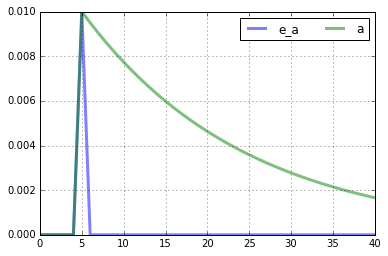

In [14]:
# Plot simulated impulse response to e_a
ar1_model.irs['e_a'][['e_a','a']].plot(lw=3,alpha=0.5,grid=True).legend(loc='upper right',ncol=2)

Next, we'll use the `.stoch_sim()` method to compute a stochastic simulation. The method takes arguments:

1. `seed`: Seed of NumPy RNG. (Optional)
2. `T`: Number of periods to simulate
3. `covMat`: Covariance matrix for exogenous shock process

The simulation should be for 201 periods.

In [15]:
# Compute stochastic simulation
ar1_model.stoch_sim(seed=126,T=201,cov_mat= [[sigma**2]])

# Print the first 10 rows of `model.simulated`
print(ar1_model.simulated.head(10))

        e_a         a
0 -0.006006  0.003344
1  0.007683  0.010860
2 -0.006501  0.003816
3 -0.000440  0.003185
4 -0.000819  0.002207
5  0.003070  0.005167
6  0.006283  0.011191
7  0.001451  0.012083
8  0.002981  0.014459
9 -0.008517  0.005219


The stochastic simulations are stored in the `.stoch_sim` attribute as a Pandas `DataFrame`.

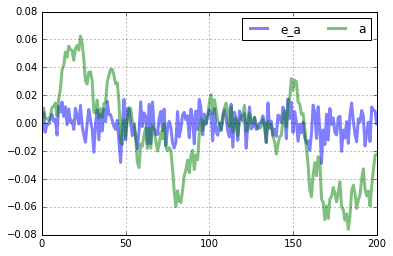

In [16]:
# Plot the stochastic simulation
ar1_model.simulated[['e_a','a']].plot(lw=3,alpha=0.5,grid=True).legend(loc='upper right',ncol=2)

## Example 2: The Stochastic Solow Growth Model Revisited

Now consider the following system of equations:

\begin{align}
Y_t & = A_t K_t^{\alpha} \\
K_{t+1} & = sY_t + (1-\delta) K_t\\
\log A_{t+1} & = \rho \log A_t + \epsilon_{t+1}
\end{align}

where $\epsilon_{t+1} \sim \mathcal{N}(0,\sigma^2)$. Let's simulate the model with `linearsolve`. Before proceding, let's also go ahead and rewrite the model with all variables moved to the lefthand side of the equations:

\begin{align}
0 & = A_t K_t^{\alpha} - Y_t \\
0 & = sY_t + (1-\delta) K_t - K_{t+1}\\
0 & = \rho \log A_t + \epsilon_{t+1} - \log A_{t+1}
\end{align}

Capital and TFP are called *state variables* because they're $t+1$ values are predetermined. Output is called a *costate* or *control* variable. Note that the model as 3 endogenous variables with 2 state variables. 

Use the following values for the simulation:

| $$\rho$$ | $$\sigma$$ | $$s$$ | $$\alpha$$ | $$\delta $$ | $$T$$  |
|----------|------------|-------|------------|-------------|--------|
| 0.75     | 0.006      | 0.1   | 0.35       |  0.025      | 201    |

### Initialization, Approximation, and Solution

The next several cells initialize the model in `linearsolve` and then approximate and solve it.

In [17]:
# Create a variable called 'parameters' that stores the model parameter values in a Pandas Series
parameters = pd.Series(dtype=float)
parameters['rho'] = .75
parameters['alpha'] = 0.35
parameters['delta'] = 0.025
parameters['s'] = 0.1

# Print the model's parameters
print(parameters)

rho      0.750
alpha    0.350
delta    0.025
s        0.100
dtype: float64


In [18]:
# Create a variable called 'sigma' that stores the value of sigma
sigma = 0.006

In [19]:
# Create variable called 'var_names' that stores the variable names in a list with state variables ordered first
var_names = ['a','k','y']

# Create variable called 'shock_names' that stores an exogenous shock name for each state variable.
shock_names = ['e_a','e_k']

In [20]:
# Define a function that evaluates the equilibrium conditions of the model solved for zero. PROVIDED
def equilibrium_equations(variables_forward,variables_current,parameters):
    
    # Parameters. PROVIDED
    p = parameters
    
    # Current variables. PROVIDED
    cur = variables_current
    
    # Forward variables. PROVIDED
    fwd = variables_forward
 
    # Production function
    production_function = cur.a*cur.k**p.alpha - cur.y
    
    # Capital evolution
    capital_evolution = p.s*cur.a*cur.k**p.alpha + (1 - p.delta)*cur.k - fwd.k
    
    # Exogenous tfp
    tfp_process = p.rho*np.log(cur.a) - np.log(fwd.a)
    
    # Stack equilibrium conditions into a numpy array
    return np.array([
        production_function,
        capital_evolution,
        tfp_process
        ])

Next, initialize the model.

In [21]:
# Initialize the model into a variable named 'solow_model'
solow_model = ls.model(equations = equilibrium_equations,
                 n_states=2,
                 var_names=var_names,
                 shock_names=shock_names,
                 parameters = parameters)

In [22]:
# Compute the steady state numerically using .compute_ss() method of solow_model
guess = [1,4,1]
solow_model.compute_ss(guess)

# Print the computed steady state
print(solow_model.ss)

a    1.000000
k    8.438129
y    2.109532
dtype: float64


In [23]:
# Find the log-linear approximation around the non-stochastic steady state and solve using .approximate_and_solve() method of solow_model
solow_model.approximate_and_solve()

### A Few Details About the Approximation (Optional)

The previous step constructs a log-linear approximation of the model and then solves for the endogenous variables as functions of the state variables and exogenous shocks only.

View the approximated model by calling the `.approximated()` method.

In [24]:
# Print the log-linear approximation to the models's equilibrium conditions
print(solow_model.approximated())

Log-linear equilibrium conditions:

             0 = -2.1095·a[t]-0.7383·k[t]+2.1095·y[t]

-8.4381·k[t+1] = -0.211·a[t]-8.301·k[t]

       -a[t+1] = -0.75·a[t]


Each variable represents the log-deviation from the steady state of the respective variable in our model. For example, the variable `y[t]` means $\log(Y_t) - \log(Y)$ in terms of the stochastic Solow model. But how do these equations relate to the original model?

The first equation appears to be:

\begin{align}
0 &= -2.1095\cdot a_t-0.7383\cdot k_t + 2.1095\cdot y_t
\end{align}

Note that dividing by 2.1095 and solving for $y_t$ yields:

\begin{align}
y_t &= a_t +0.3499\cdot k_t,
\end{align}

so the coefficient on $k_t$ appears to be close to $\alpha=0.35$. We can derive this linear equation directly. First, start with the production function:

\begin{align}
Y_t &= A_t K_t^{\alpha}.
\end{align}

Then divide both sides by steady state output:

\begin{align}
\frac{Y_t}{Y} &= \frac{A_t K_t^{\alpha}}{AK^{\alpha}} \, = \, \frac{A_t}{A}\frac{K_t^{\alpha}}{K^{\alpha}}.
\end{align}

Then, take the log of both sides:
\begin{align}
\log\left(\frac{Y_t}{Y} \right)&= \log\left(\frac{A_t}{A}\right) + \alpha\log\left(\frac{K_t}{K}\right).
\end{align}

finally, letting $y_t = \log(Y_t/Y)$, k_t = $\log(K_t/K)$, and $a_t = \log(A_t/A)$, we have:

\begin{align}
y_t &= a_t + \alpha k_t.
\end{align}

However, understanding this process isn't as important as being able to interpret the graphs and statistics that compute using the output of `linearsolve`.

### A Few Details About the Solution (Optional)

It's also worth seeing what it means for a model to be *solved*. After `linearsolve` computes the log-linear approximation to the model, it solves for each endogenous variable as a function of state variables only. View the solved model by calling the `.solved()` method.

In [25]:
# Print the solved model
print(solow_model.solved())

Solution to the log-linear system:

a[t+1] = 0.75·a[t]+e_a[t+1]

k[t+1] = 0.025·a[t]+0.9837·k[t]+e_k[t+1]

  y[t] = a[t]+0.35·k[t]


### Impulse Responses

Compute a 41 period impulse responses of the model's variables to a 0.01 unit shock to TFP in period 5.

In [26]:
# Compute impulse responses
solow_model.impulse(T=41,t0=5,shocks=[0.01,0])

# Print the first 10 rows of the computed impulse responses.
print(solow_model.irs['e_a'].head(10))

    e_a         a         k         y
0  0.00  0.000000  0.000000  0.000000
1  0.00  0.000000  0.000000  0.000000
2  0.00  0.000000  0.000000  0.000000
3  0.00  0.000000  0.000000  0.000000
4  0.00  0.000000  0.000000  0.000000
5  0.01  0.010000  0.000000  0.010000
6  0.00  0.007500  0.000250  0.007588
7  0.00  0.005625  0.000433  0.005777
8  0.00  0.004219  0.000567  0.004417
9  0.00  0.003164  0.000663  0.003396


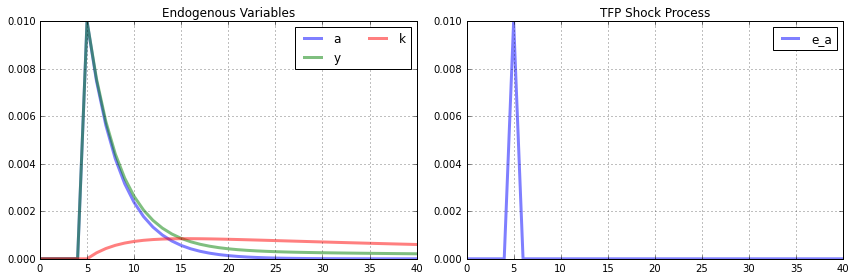

In [27]:
# Plot the computed impulse responses to a TFP shock
fig = plt.figure(figsize=(12,4))

ax1 = fig.add_subplot(1,2,1)
solow_model.irs['e_a'][['a','y','k']].plot(lw=3,alpha=0.5,grid=True,ax = ax1).legend(loc='upper right',ncol=2)
ax1.set_title('Endogenous Variables')

ax2 = fig.add_subplot(1,2,2)
solow_model.irs['e_a'][['e_a']].plot(lw=3,alpha=0.5,grid=True,ax = ax2).legend(loc='upper right',ncol=2)
ax2.set_title('TFP Shock Process')

fig.tight_layout()

### Stochastic Simulation

Compute a 201 period stochastic simulation of the model's variables. Set the variance of $\epsilon_t$ to $\sigma^2$ and the variance of the shock to capital to 0 so that the covariance matrix for the shock process is:

\begin{align}
\text{Covariance matrix} & = \left[\begin{array}{cc} \sigma^2 & 0\\ 0 & 0\end{array} \right]
\end{align}

In [28]:
# Compute stochastic simulation and print the simulated values.
solow_model.stoch_sim(seed=126,T=201,cov_mat= [[sigma**2,0],[0,0]])

# Print first 10 rows of model.simulated
print(solow_model.simulated.head(10))

        e_a  e_k         a         k         y
0  0.001484  0.0  0.003862  0.000649  0.004089
1  0.001427  0.0  0.004323  0.000735  0.004580
2  0.003155  0.0  0.006397  0.000831  0.006688
3  0.011305  0.0  0.016103  0.000978  0.016445
4 -0.001778  0.0  0.010299  0.001364  0.010777
5 -0.013211  0.0 -0.005486  0.001600 -0.004927
6  0.004054  0.0 -0.000060  0.001437  0.000442
7  0.006153  0.0  0.006108  0.001412  0.006602
8 -0.001336  0.0  0.003245  0.001541  0.003785
9 -0.006801  0.0 -0.004367  0.001598 -0.003808


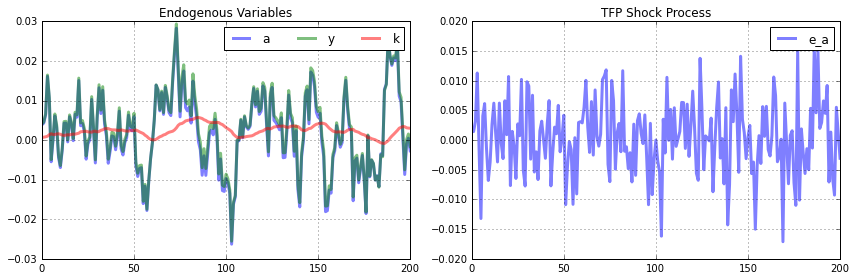

In [29]:
# Plot the computed stochastic simulation
fig = plt.figure(figsize=(12,4))

ax1 = fig.add_subplot(1,2,1)
solow_model.simulated[['a','y','k']].plot(lw=3,alpha=0.5,grid=True,ax = ax1).legend(loc='upper right',ncol=3)
ax1.set_title('Endogenous Variables')

ax2 = fig.add_subplot(1,2,2)
solow_model.simulated[['e_a']].plot(lw=3,alpha=0.5,grid=True,ax = ax2).legend(loc='upper right',ncol=2)
ax2.set_title('TFP Shock Process')

fig.tight_layout()

In [30]:
# Compute standard deviations of simulated TFP, output, and capital
solow_model.simulated[['a','y','k']].std()

a    0.009478
y    0.009484
k    0.001385
dtype: float64

In [31]:
# Compute correlation coefficients of simulated TFP, output, and capital
solow_model.simulated[['a','y','k']].corr()

,a,y,k
a,1.000000,0.998694,-0.012365
y,0.998694,1.000000,0.038745
k,-0.012365,0.038745,1.000000
